In [123]:
# подгружаем все нужные пакеты
import pandas as pd
import numpy as np

# import pandas_profiling as pp

import os
import sys
import math
import string
import itertools as it
from transliterate import translit

from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split

# для встроенных картинок
%pylab inline
# чуть покрасивше картинки:
pd.set_option('display.mpl_style', 'default')
figsize(12, 9)

import warnings
warnings.filterwarnings("ignore")

#plt.rcParams['figure.figsize'] = 10, 7.5
#plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
# import seaborn as sns


import matplotlib as mpl
mpl.rcParams['font.family'] = 'Verdana' # Ubuntu

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

# чтобы был русский шрифт
from matplotlib import rc
 
font = {'family': 'Verdana', #Droid Sans
        'weight': 'normal'}
rc('font', **font)
import pickle as pkl
import random

Populating the interactive namespace from numpy and matplotlib


In [124]:
pd.options.display.max_colwidth = 100

In [125]:
import gzip

In [126]:
import folium

## Reading

In [127]:
df_orders_drivers = pd.read_csv('./orders_drivers.csv')
df_orders_riders  = pd.read_csv('./orders_riders.csv')
df_geo_stream     = pd.read_csv('./geo_stream.csv')
df_reviews        = pd.read_csv('./reviews.csv', sep=';')
with gzip.open('./driver_paths.csv.gz') as f:
    df_driver_paths = pd.read_csv(f)

## Geo stream

статусы: ['busy', 'in_order', 'free', 'routing', 'none']

None можно смело выкинуть

In [128]:
df_geo_stream.head()

,drivergk,latitude,longitude,status,gps_at,speed
0,4176,55.925782,37.516895,busy,2017-09-01 14:47:53,2.361546
1,7104,55.625518,37.417599,in_order,2017-09-01 14:47:57,25.859999
2,7104,55.625425,37.417235,in_order,2017-09-01 14:47:56,25.210000
3,7104,55.625332,37.416873,in_order,2017-09-01 14:47:55,24.560000
4,7104,55.625242,37.416523,in_order,2017-09-01 14:47:54,24.070000


In [129]:
df_geo_stream = df_geo_stream[df_geo_stream.status != 'none']

In [130]:
df_geo_stream['ts'] = pd.to_numeric(pd.to_datetime(df_geo_stream.gps_at)) / 1000000000

In [131]:
df_geo_stream['dt'] = pd.to_datetime(df_geo_stream.gps_at)

In [132]:
df_ofr = df_geo_stream[(df_geo_stream.status!='busy')]

In [133]:
dict_map = {'in_order':-1, 'free':1, 'routing':0}

In [134]:
df_ofr = df_ofr.replace({'status': dict_map})

In [135]:
pd.options.display.max_rows=300

In [91]:
def get_orig_dest(x):
    x = x.sort_values(by='dt')
    x['changed'] = x['status'].diff().fillna(0.0)#.reset_index()
    x = x[x.status==-1].reset_index(drop=True)
    changed_idx = x[x.changed!=0].index
    print(x.iloc[changed_idx][['latitude', 'longitude']])
#     print(x.iloc[-1][['latitude', 'longitude']])
#     print(changed_idx)
    return x

In [140]:
from tqdm import tqdm

In [144]:
df_ofr.drivergk.nunique()

8446

In [141]:
#.apply(lambda x: get_orig_dest(x[['latitude', 'longitude', 'dt', 'status']]))
list_of_pairs = []
cnt = 0
for i, x in tqdm(df_ofr.groupby('drivergk')):
    x = x.sort_values(by='dt')
    x['changed'] = x['status'].diff().fillna(0.0)#.reset_index()
    x = x[x.status==-1].reset_index(drop=True)
    changed_idx = list(x[x.changed!=0].index)
#     print(x[['latitude', 'longitude', 'status', 'changed']])
    if len(changed_idx)>0:
        changed_idx_add = [val-1 for val in changed_idx if val>0] + [len(x)-1]
        changed_idx +=changed_idx_add
    #     print(changed_idx_add)
    #     print(x[['latitude', 'longitude', 'changed']])
        l = [tuple(v) for v in x.iloc[changed_idx][['latitude', 'longitude']].values]
        pairs = list(zip(l[::2], l[1::2]))
        list_of_pairs += pairs
    else:
        if len(x)>1:
            l = [tuple(v) for v in x.iloc[[0, len(x)-1]][['latitude', 'longitude']].values]
            pairs = list(zip(l[::2], l[1::2]))
#             list_of_pairs += pairs
#     cnt+=1
#     if cnt % 100 == 0:
#         print(cnt)

100%|██████████| 8446/8446 [00:54<00:00, 153.66it/s]


In [148]:
pd.DataFrame([[pair[0][0], pair[0][1], pair[1][0], pair[1][1]] for pair in list_of_pairs], columns=['x_lat', 'x_lon', 'y_lat', 'y_lon']).to_csv('for_lenya.csv', index=None)

In [142]:
len(list_of_pairs)

84313

In [ ]:
df_order_free

In [21]:
driver_states = driver_states.unstack().dropna()

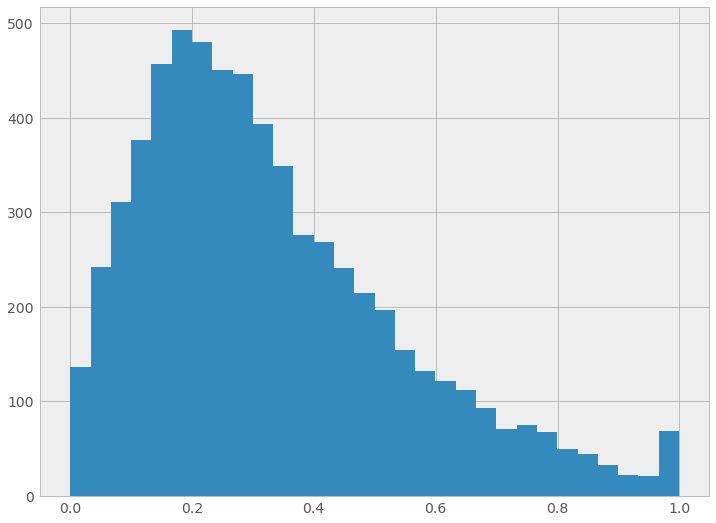

In [24]:
driver_states.free.hist(bins=30)

In [12]:
df_geo_free = df_geo_stream[df_geo_stream.status=='free']

In [11]:
df_geo_stream.status.value_counts(normalize=True)

busy        0.430789
in_order    0.393581
free        0.173800
routing     0.001831
Name: status, dtype: float64

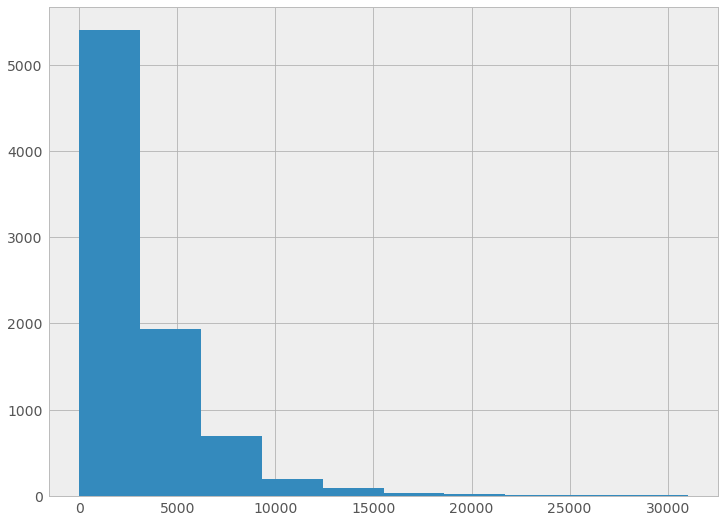

In [15]:
df_geo_free.groupby('drivergk').agg({})

In [18]:
sizes = df_geo_stream.groupby('drivergk').size()

In [21]:
sizes.median() # медианное количество точек на драйвера

13999.0

In [24]:
df_geo_stream.columns

Index(['drivergk', 'latitude', 'longitude', 'status', 'gps_at', 'speed'], dtype='object')

In [23]:
m_drivers = folium.Map([55.752992, 37.621080], zoom_start=10)

In [28]:
df_geo_test = df_order_free.groupby('drivergk').get_group(2)

In [34]:
i = 0
for j, gr in df_geo_stream.groupby('drivergk'):
    points = [tuple(x) for x in gr[['latitude', 'longitude']].values]
    r = lambda: random.randint(0,255)
    folium.PolyLine(points, color='#%02X%02X%02X' % (r(),r(),r()), weight=2.5, opacity=1).add_to(m_drivers)
    i+=1
    if i > 5: break

In [54]:
pd.set_option('float_format', '{:f}'.format)

In [56]:
df_geo_test['ts'] = pd.to_numeric(pd.to_datetime(df_geo_test.gps_at)) / 1000000000

In [72]:
from sklearn.cluster import DBSCAN

In [73]:
clf = DBSCAN()
markers = clf.fit_predict()

In [29]:
coord_test = df_geo_test[['latitude', 'longitude']].as_matrix()

In [99]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [101]:
speed = sc.fit_transform(df_geo_test[['speed']])

(array([ 4312.,  1162.,  1242.,  1349.,  1259.,  1397.,  1556.,   552.,
          412.,   177.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

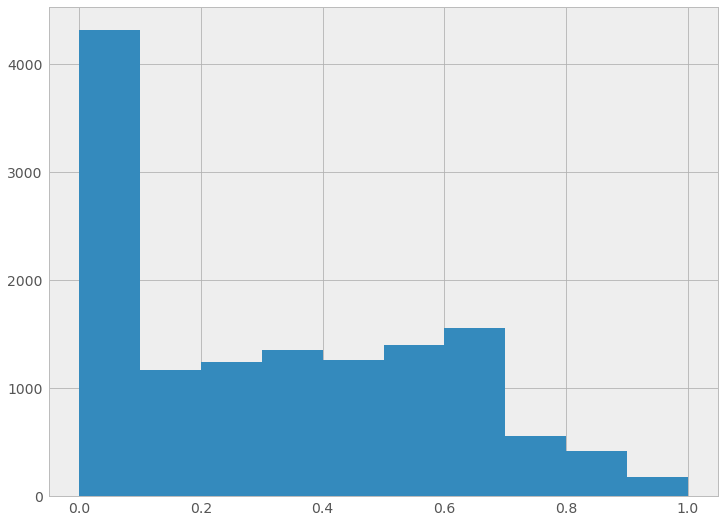

In [115]:
plt.hist(speed)

In [2]:
plt.scatter(coord_test[:,0], coord_test[:,1], c=1-speed, cmap=plt.get_cmap('RdYlGn'))

NameError: name 'coord_test' is not defined

In [ ]:
m_driver_test = folium.Map([55.752992, 37.621080], zoom_start=10)
for coord in coord_test:
    folium.CircleMarker(coord, radius=2).add_to(m_driver_test)

m_driver_test.save(os.path.join('maps_html', 'random_driver_stream.html'))

In [77]:
pd.DataFrame(markers)[0].value_counts()

0    22172
Name: 0, dtype: int64

In [93]:
df_geo_test = df_geo_test.reset_index(drop=True)

In [105]:
import geopy

In [34]:
from geopy.distance import vincenty

In [36]:
df_geo_test = df_geo_test.reset_index(drop=True)
m_driver_test = folium.Map([55.752992, 37.621080], zoom_start=10)
points = []

prev_point = df_geo_test.loc[0][['latitude', 'longitude']].values
points+=[prev_point]
for i, point in df_geo_test.iterrows():
    if i==0: 
        continue
    cur_point = point[['latitude', 'longitude']].values
#     if cur_point[2] - prev_point[2] > 20: 
    if vincenty(cur_point, prev_point).km > 0.2:
        r = lambda: random.randint(0,255)
        folium.PolyLine([(p[0], p[1]) for p in points], color='#%02X%02X%02X' % (r(),r(),r()), weight=4.5, opacity=1).add_to(m_driver_test)
        points = [cur_point]
    else:
        points += [cur_point]
    
    prev_point = cur_point

    
if points:
    r = lambda: random.randint(0,255)
    folium.PolyLine([(p[0], p[1]) for p in points], color='#%02X%02X%02X' % (r(),r(),r()), weight=4.5, opacity=1).add_to(m_driver_test)
    
    
m_driver_test.save(os.path.join('maps_html', 'random_driver_stream.html'))

In [32]:
m_drivers.save(os.path.join('maps_html', 'geo_stream_test.html'))

NameError: name 'm_drivers' is not defined